# 3. Classifier Models - MLP

In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random

import sys
sys.path.append('..')

from data_loading import *
from embeddings.hold2vec import *
from embeddings.route_embeddings import *
from visualization import plot_route

2023-04-29 12:34:17.324508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## MLP with Hold2Vec Embeddings

### Loading the Data

In [2]:
df = load_dataframe('../data/2017.json')
df = add_font_scale_column(df)
df = add_v_grade(df)
# df = df[df.v_grade < 7]
df.head()

,Grade,UserRating,Moves,font_scale,v_grade_str,v_grade
0,6A+,1,"[H5, E7, F8, D10, E13, C14, C16, B18, E18, F9,...",0,V3,0
1,6A+,2,"[H5, E7, D8, D10, E13, C14, C16, B18, E18]",0,V3,0
2,6B+,2,"[A4, B4, C7, D9, F12, D15, F18]",2,V4,1
3,6A+,2,"[K4, J4, I7, H9, I10, F12, F13, E6, B14, C16, ...",0,V3,0
4,6B+,2,"[G8, D9, F12, C13, F15, D17, F18, E6, G4, F4]",2,V4,1


### Building Embeddings

In [3]:
filename = 'hold2vec_skip-gram_embedding100_window8_epochs20.npy'

hold_embeddings_matrix = load_hold_matrix(filename = '../data/embeddings/' + filename)
hold_embeddings_matrix = hold_embeddings_matrix.T

weights = tf_idf_weights(df.Moves)
embeddings = pooled_embedding(df.Moves, hold_embeddings=hold_embeddings_matrix, pool_method='sum', weights=weights)

### Train / Test Split

In [4]:
y = np.array(df.v_grade)
#X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

### Training the MLP Classifier

In [5]:
classifier = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(20,15,), solver='lbfgs', alpha=0.00015)
classifier.fit(X_train, y_train)

/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.00015, hidden_layer_sizes=(20, 15), max_iter=300,
              random_state=42, solver='lbfgs')

### Report: Classification of Training Data

In [6]:
y_train_pred = classifier.predict(X_train)

sk_report_train = classification_report(
    digits=4,
    y_true= y_train, 
    y_pred= y_train_pred
)
print(sk_report_train)

print("Confusion Matrix")
for a in confusion_matrix(y_train, y_train_pred):
    for b in a:
        print(f'{b:4d}', end=' ')
    print()

              precision    recall  f1-score   support

           0     0.7081    0.7676    0.7367      4871
           1     0.4244    0.3369    0.3756      3372
           2     0.4426    0.6373    0.5224      3785
           3     0.2577    0.0354    0.0623      1186
           4     0.0000    0.0000    0.0000       479
           5     0.3695    0.5009    0.4253      1122
           6     0.0000    0.0000    0.0000       190
           7     0.0000    0.0000    0.0000        62
           8     0.0000    0.0000    0.0000        13
           9     0.0000    0.0000    0.0000         4
          10     0.0000    0.0000    0.0000         8

    accuracy                         0.5229     15092
   macro avg     0.2002    0.2071    0.1929     15092
weighted avg     0.4821    0.5229    0.4892     15092

Confusion Matrix
3739  710  391    5    0   26    0    0    0    0    0 
1152 1136 1044    7    0   33    0    0    0    0    0 
 346  743 2412   41    0  242    1    0    0    0    0 
  

/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Report: Classification of Validation Data

In [7]:
y_test_pred = classifier.predict(X_test)

sk_report_test = classification_report(
    digits=4,
    y_true= y_test, 
    y_pred= y_test_pred
)
print(sk_report_test)
matrix = confusion_matrix(y_test, y_test_pred, normalize='true')

print("Confusion Matrix")
for a in confusion_matrix(y_test, y_test_pred):
    for b in a:
        print(f'{b:4d}', end=' ')
    print()

              precision    recall  f1-score   support

           0     0.7062    0.7461    0.7256      1276
           1     0.3598    0.3085    0.3322       765
           2     0.4117    0.5809    0.4819       983
           3     0.1622    0.0213    0.0376       282
           4     0.0000    0.0000    0.0000       114
           5     0.3866    0.4784    0.4277       278
           6     0.0000    0.0000    0.0000        48
           7     0.0000    0.0000    0.0000        13
           8     0.0000    0.0000    0.0000         9
           9     0.0000    0.0000    0.0000         2
          10     0.0000    0.0000    0.0000         3

    accuracy                         0.5030      3773
   macro avg     0.1842    0.1941    0.1823      3773
weighted avg     0.4596    0.5030    0.4726      3773

Confusion Matrix
 952  192  125    1    0    6    0    0    0    0    0 
 245  236  270    2    0   12    0    0    0    0    0 
 137  196  571   17    0   61    1    0    0    0    0 
  

/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminglaus/miniconda3/envs/data/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

['H6', 'C3', 'D8', 'E11', 'B14', 'G15', 'G16', 'K18']
    V3 0.12%
    V4 2.30%
    V5 28.76%
    V6 12.10%
    V7 19.00%
>   V8 30.32%
    V9 4.07%
   V10 2.59%
   V11 0.37%
   V12 0.08%
   V13 0.30%


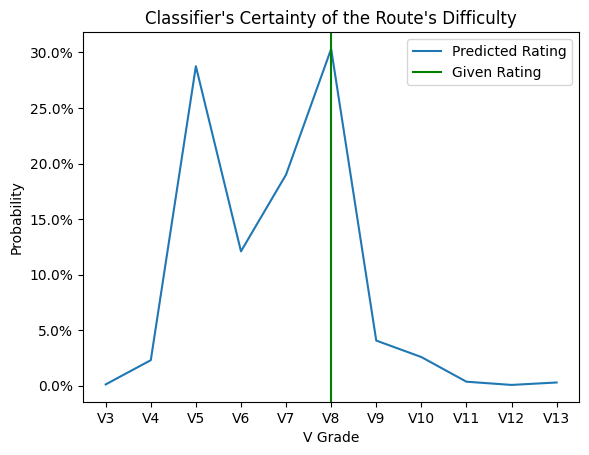

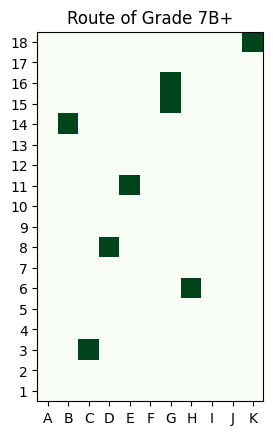

In [9]:
# predict probabilities of grades for route at index route_i
route_i = random.choice(list(df[df.v_grade > 3].index)) # choose a random route (harder then)

route = df.Moves[route_i]
embedded_route = pooled_embedding([route], hold_embeddings=hold_embeddings_matrix, pool_method='sum', weights=weights)

y_true = df.v_grade[route_i]
y_probas = classifier.predict_proba(embedded_route)

# print the route
print(route)

# print out the probabilities
n = len(y_probas[0])
int_to_V_grade = {v: k for k, v in V_GRADE.items()}

for i in range(n):
    print('> ' if i == y_true else '  ', end='')
    print(f'{int_to_V_grade[i]:>4} {y_probas[0][i]*100:.2f}%')
    
# plot the probability distribution of the classifiers prediction
plt.plot(y_probas[0], label='Predicted Rating')
plt.axvline(x=y_true, color='green', label='Given Rating')

plt.xlabel("V Grade")
plt.xticks(list(V_GRADE.values()), list(V_GRADE.keys()))

plt.ylabel("Probability")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title("Classifier's Certainty of the Route's Difficulty")
#plt.ylim(0,1)
plt.legend()

plt.show()

# plot the route
plot_route(df, route_i)